### Linear Programming using pyomo solver GLPK


In [ ]:
!pip install -q pyomo

     |████████████████████████████████| 9.5MB 4.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 256kB 39.1MB/s 
     |████████████████████████████████| 163kB 42.7MB/s 


In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Setting up libcolamd2:amd64 (1:5.1.2-2) ...
Setting up libamd2:amd64 

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import random
import time
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory

### LP with GLPK solver

In [ ]:
def glpk_opt(A):  
  model = ConcreteModel()
  model.Agents = range(len(A))
  model.Objects = range(len(A.T))
  model.x = Var( model.Agents, model.Objects,bounds=(0.0,1.0) )
  model.y = Var( model.Agents, within=Binary )

  #Objective
  model.obj = Objective(expr = sum(A[n,m]*model.x[n,m] for n in model.Agents for m in model.Objects),sense=maximize )

  ###Constraints
  model.single_x = ConstraintList()
  for m in model.Objects:
    model.single_x.add(sum( model.x[n,m] for n in model.Agents ) == 1.0 )
    
  for m in model.Agents:
    model.single_x.add(sum( model.x[m,n] for n in model.Objects ) <= 1.0 )

  # create a solver
  solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

  # solve
  solver.solve(model)
  a=dict()
  for n in model.Agents:
    a[n]= []
    for m in model.Objects:
      a[n].append(value(model.x[n,m])*A[n,m])

  assign=dict()
  for n in model.Agents:
    assign[n]= []
    for m in model.Objects:
      assign[n].append(value(model.x[n,m]))
  total=value(model.obj)       
  return a,assign,total    

###Auction Algorithm

In [ ]:
import random
import time

def AuctionAlgo(val_mat,agents,prices):
  N = len(val_mat)
  M = len(val_mat[0])
  ep = 1/(1+ N)

  agents,prices = initialize(agents,prices,N)
  unassigned = []
  while (-1 in agents.values()):    
    max = 0
    temp = 0
    unassigned_agent = checkAgents(agents)
    agents_row = val_mat[unassigned_agent]

    for j in range(0, N):
      value = agents_row[j] - prices[j]
      if value > max:
          max = value
          obj = j

    max2 = 0
    for l in range(0, N):
      value = agents_row[l] - prices[l]
      if value > max2 and value < max:
          max2 = value

    bid = max - max2 + ep
    agents[unassigned_agent] = obj

    for key, value in agents.items():
        if value is obj and key is not unassigned_agent:
            agents[key] = -1
            unassigned.append(key)
    prices[obj] =prices[obj]+ bid
  return agents


def checkAgents(agents):
  for key, value in agents.items():
      if value is -1:
        return key

def initialize(agents,prices,N):
    for i in range(0, N):
      agents[i] = -1
      prices[i] = 0
    return agents,prices

def calculateAssignmentValue(val_mat, agents):
    total = 0
    for key, value in agents.items():
        total =total+ val_mat[key][value]
    return total   

###Random Assignment Generation:

In [ ]:
def dataGeneration(n,M):
    return np.random.randint(0, M, size=(n, n))

In [ ]:
A =dataGeneration(10,9)

In [ ]:
### testing for GLPK solver
a,assign,total = glpk_opt(A)

In [ ]:
print("Assignemnt for GLPK solver")
for i in assign.keys():
  print(" "+str(i)+":"+str(assign[i].index(max(assign[i]))))

Assignemnt for GLPK solver
 0:1
 1:2
 2:8
 3:9
 4:7
 5:5
 6:3
 7:4
 8:0
 9:6


In [ ]:
### testing for auction algorithm
agents={}
prices={}
al = AuctionAlgo(A,agents,prices)
print("The actual assignment for auction algorithm=")
print("(Agent:Object)")
print(al)

The actual assignment for auction algorithm=
(Agent:Object)
{0: 1, 1: 2, 2: 8, 3: 9, 4: 4, 5: 5, 6: 3, 7: 7, 8: 0, 9: 6}


#Computing the per-agent average value of assignments for  n= 2 to 256 using Auction Algorithm

In [ ]:
# Commenting out as it takes a lot of time to generate
# n_agent_avg=[]
# for x in (2**p for p in range(1,9)):
#   sum =0
#   for i in range(0,1000):    
#     mat = np.array(dataGeneration(x,100))
#     agents={}
#     prices={}
#     al = AuctionAlgo(mat,agents,prices)
#     total = calculateAssignmentValue(mat,al)
#     sum=sum+total
#   avg = sum/1000  
#   n_agent_avg.append(avg/x) 

KeyboardInterrupt: ignored

In [ ]:
# print("Per_agent average value",n_agent_avg)

Per_agent average value [60.8315, 73.23225, 83.349625, 90.36925, 94.6445625, 97.002]


### Per Agent Average Value

In [ ]:
def plot_per_agent_avg(n,M,iteration):
  total=np.zeros((n,1))
  for i in range(iteration):
    mat= np.array(dataGeneration(n,M))
    agents={}
    prices={}
    al = AuctionAlgo(mat,agents,prices)
    for key, value in al.items():
      total[key]+=mat[key][value]

  ag=[x for x in range(n)]
  total=total/iteration
  total=total.reshape((1,n))
  total=[total[0][j] for j in range(n)]
  plt.figure(figsize=(10, 6))
  plt.plot(ag,total)
  plt.xlabel('Agents',fontsize=14)
  plt.ylabel('Average value for each agent',fontsize=14)
  # plt.xticks(np.arange(n))
  plt.title("Average value for each agent while agent="+str(n),fontsize=14)
  plt.savefig("auction"+str(n)+".png", dpi=200,fontsize=14)
  plt.show()

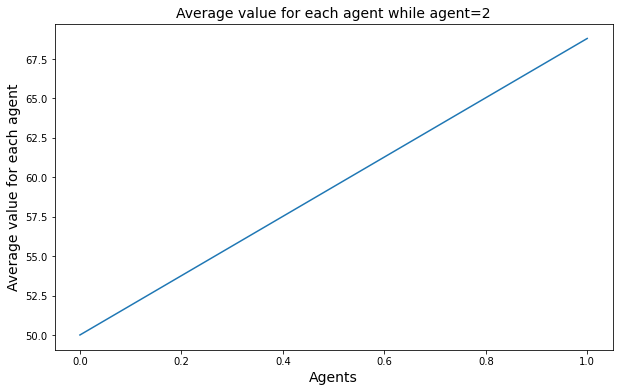

In [ ]:
#plot_per_agent_avg(2,100,1000) # Commenting out as it takes a lot of time to generate
